# 12.1a: Initialization Sigma Sweep

**Goal:** Find the optimal σ for snowball initialization that reproduces Qwen-like black hole structure.

## Target Properties

From Qwen2.5-3B-Instruct (07.3n):
- 60 black holes from ~2,200 dead tokens
- All within 2ε hypercube (max L∞ = 6×10⁻⁵)
- Mix of black holes and singletons

## Sweep Strategy

Initialize 128-token vocabulary with:
```python
embeddings = base_vector + Gaussian(0, σ)
```

Then measure geometric properties for many values of σ.

**Sweep range:** σ ∈ [1×10⁻⁶, 1×10⁻⁴] (1000 points, evenly spaced)

## Measurements

For each σ:
1. Unique vectors (after bfloat16 quantization)
2. Black hole count (vectors with population ≥ 2)
3. Black hole population (total tokens in black holes)
4. Singleton count (unique vectors)
5. Max L∞ distance (pairwise)
6. Mean L∞ distance
7. % touching pairs (L∞ ≤ 2ε)
8. Largest black hole size

This will give us a high-resolution curve to understand how σ controls the snowball structure.

## Parameters

In [1]:
# Model parameters
VOCAB_SIZE = 128
HIDDEN_DIM = 64

# Sweep parameters
SIGMA_MIN = 1e-6
SIGMA_MAX = 1e-4
N_SAMPLES = 1000  # High resolution!

# Reference scale
EPSILON = 3e-5  # bfloat16 ULP at relevant magnitude

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Define Measurement Function

In [3]:
def measure_initialization_geometry(sigma, vocab_size, hidden_dim, epsilon):
    """
    Initialize embeddings with Gaussian noise, quantize to bfloat16,
    and measure geometric properties.
    
    Returns dict with measurements.
    """
    # Generate base vector
    base_vector = torch.randn(hidden_dim)
    
    # Add Gaussian noise
    noise = torch.randn(vocab_size, hidden_dim) * sigma
    embeddings = base_vector + noise
    
    # Quantize to bfloat16
    embeddings = embeddings.to(torch.bfloat16).to(torch.float32)
    
    # Find unique vectors
    unique_vectors, inverse_indices, counts = torch.unique(
        embeddings,
        dim=0,
        return_inverse=True,
        return_counts=True
    )
    
    # Black holes (count ≥ 2)
    black_hole_mask = counts >= 2
    n_black_holes = black_hole_mask.sum().item()
    black_hole_population = counts[black_hole_mask].sum().item() if n_black_holes > 0 else 0
    largest_bh = counts.max().item()
    n_singletons = len(unique_vectors) - n_black_holes
    
    # Pairwise L∞ distances
    v1 = embeddings.unsqueeze(1)  # [n, 1, d]
    v2 = embeddings.unsqueeze(0)  # [1, n, d]
    diffs = v1 - v2  # [n, n, d]
    l_inf_distances = torch.abs(diffs).max(dim=2)[0]  # [n, n]
    
    # Remove diagonal
    mask = ~torch.eye(vocab_size, dtype=torch.bool)
    l_inf_nondiag = l_inf_distances[mask]
    
    # Statistics
    max_l_inf = l_inf_nondiag.max().item()
    mean_l_inf = l_inf_nondiag.mean().item()
    median_l_inf = l_inf_nondiag.median().item()
    
    # Touching pairs
    touching_pairs = (l_inf_nondiag <= 2 * epsilon).sum().item()
    total_pairs = len(l_inf_nondiag)
    pct_touching = 100 * touching_pairs / total_pairs
    
    return {
        'sigma': sigma,
        'unique_vectors': len(unique_vectors),
        'n_black_holes': n_black_holes,
        'black_hole_population': black_hole_population,
        'n_singletons': n_singletons,
        'largest_bh': largest_bh,
        'max_l_inf': max_l_inf,
        'mean_l_inf': mean_l_inf,
        'median_l_inf': median_l_inf,
        'pct_touching': pct_touching,
    }

print("✓ Measurement function defined")

✓ Measurement function defined


## Run Sweep

In [4]:
print(f"Running sigma sweep: σ ∈ [{SIGMA_MIN:.2e}, {SIGMA_MAX:.2e}]")
print(f"Samples: {N_SAMPLES:,}")
print(f"Vocabulary: {VOCAB_SIZE} tokens, {HIDDEN_DIM}D embeddings\n")

# Generate sigma values (evenly spaced)
sigmas = np.linspace(SIGMA_MIN, SIGMA_MAX, N_SAMPLES)

# Collect measurements
results = []

for sigma in tqdm(sigmas, desc="Sweeping σ"):
    measurements = measure_initialization_geometry(sigma, VOCAB_SIZE, HIDDEN_DIM, EPSILON)
    results.append(measurements)

print(f"\n✓ Sweep complete: {len(results):,} measurements collected")

Running sigma sweep: σ ∈ [1.00e-06, 1.00e-04]
Samples: 1,000
Vocabulary: 128 tokens, 64D embeddings



Sweeping σ:   0%|          | 0/1000 [00:00<?, ?it/s]


✓ Sweep complete: 1,000 measurements collected


## Convert to Arrays for Plotting

In [5]:
# Extract arrays
sigma_array = np.array([r['sigma'] for r in results])
unique_vectors = np.array([r['unique_vectors'] for r in results])
n_black_holes = np.array([r['n_black_holes'] for r in results])
black_hole_population = np.array([r['black_hole_population'] for r in results])
n_singletons = np.array([r['n_singletons'] for r in results])
largest_bh = np.array([r['largest_bh'] for r in results])
max_l_inf = np.array([r['max_l_inf'] for r in results])
mean_l_inf = np.array([r['mean_l_inf'] for r in results])
median_l_inf = np.array([r['median_l_inf'] for r in results])
pct_touching = np.array([r['pct_touching'] for r in results])

print("✓ Data converted to arrays")

✓ Data converted to arrays


## Plot 1: Black Hole Structure vs σ

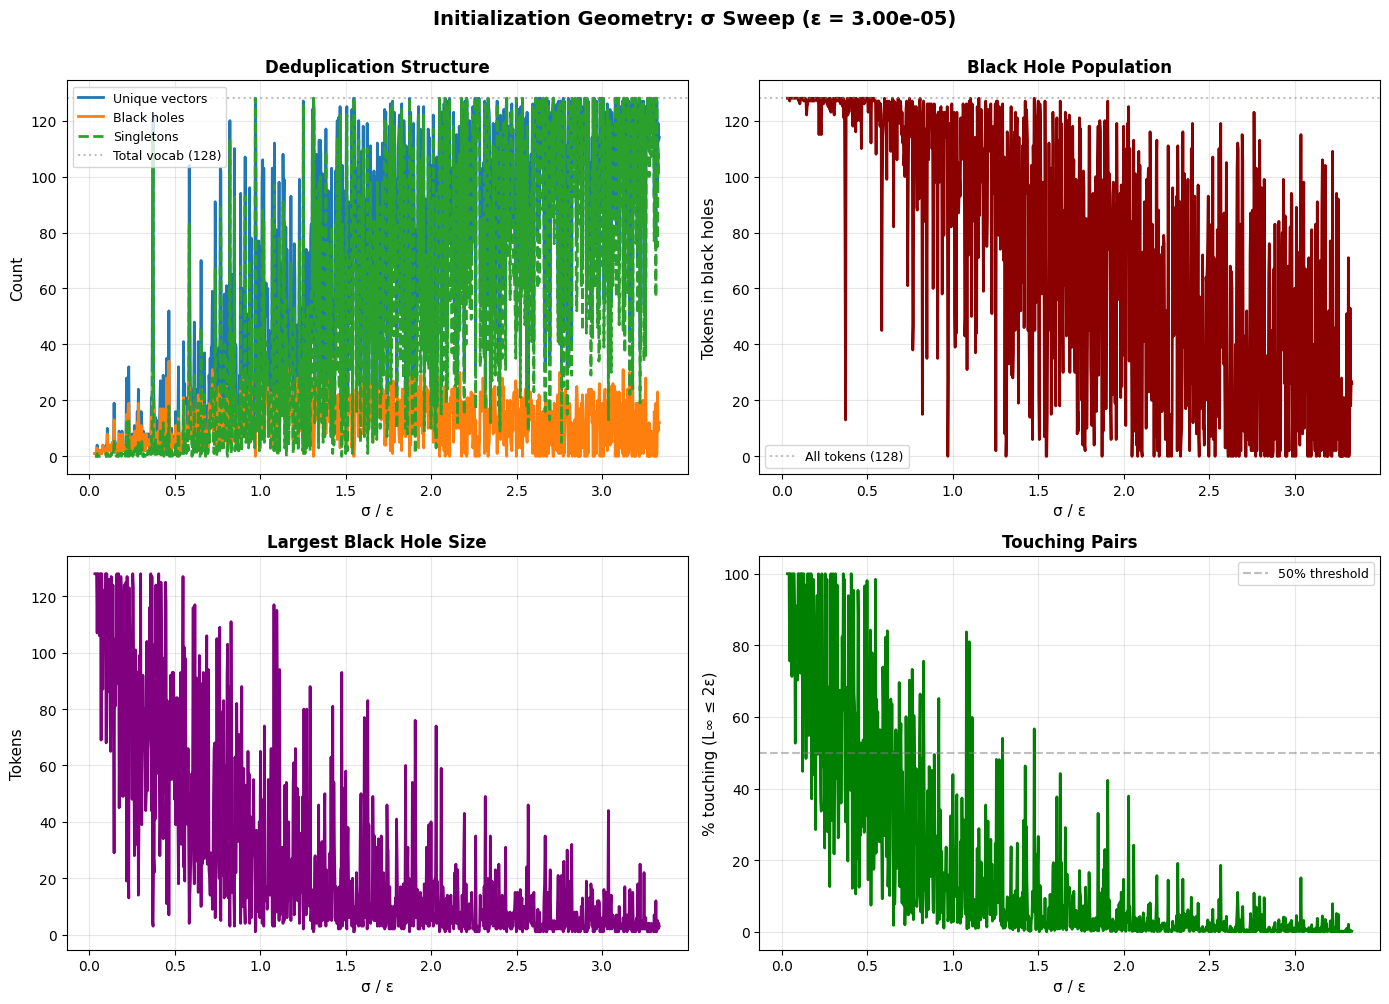

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

# Top-left: Unique vectors and black holes
ax = axes[0, 0]
ax.plot(sigma_array / EPSILON, unique_vectors, label='Unique vectors', linewidth=2)
ax.plot(sigma_array / EPSILON, n_black_holes, label='Black holes', linewidth=2)
ax.plot(sigma_array / EPSILON, n_singletons, label='Singletons', linewidth=2, linestyle='--')
ax.axhline(VOCAB_SIZE, color='gray', linestyle=':', alpha=0.5, label=f'Total vocab ({VOCAB_SIZE})')
ax.set_xlabel("σ / ε", fontsize=11)
ax.set_ylabel("Count", fontsize=11)
ax.set_title("Deduplication Structure", fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Top-right: Black hole population
ax = axes[0, 1]
ax.plot(sigma_array / EPSILON, black_hole_population, color='darkred', linewidth=2)
ax.axhline(VOCAB_SIZE, color='gray', linestyle=':', alpha=0.5, label=f'All tokens ({VOCAB_SIZE})')
ax.set_xlabel("σ / ε", fontsize=11)
ax.set_ylabel("Tokens in black holes", fontsize=11)
ax.set_title("Black Hole Population", fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Bottom-left: Largest black hole
ax = axes[1, 0]
ax.plot(sigma_array / EPSILON, largest_bh, color='purple', linewidth=2)
ax.set_xlabel("σ / ε", fontsize=11)
ax.set_ylabel("Tokens", fontsize=11)
ax.set_title("Largest Black Hole Size", fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Bottom-right: Touching percentage
ax = axes[1, 1]
ax.plot(sigma_array / EPSILON, pct_touching, color='green', linewidth=2)
ax.axhline(50, color='gray', linestyle='--', alpha=0.5, label='50% threshold')
ax.set_xlabel("σ / ε", fontsize=11)
ax.set_ylabel("% touching (L∞ ≤ 2ε)", fontsize=11)
ax.set_title("Touching Pairs", fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

plt.suptitle(f"Initialization Geometry: σ Sweep (ε = {EPSILON:.2e})", fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Plot 2: Distance Statistics vs σ

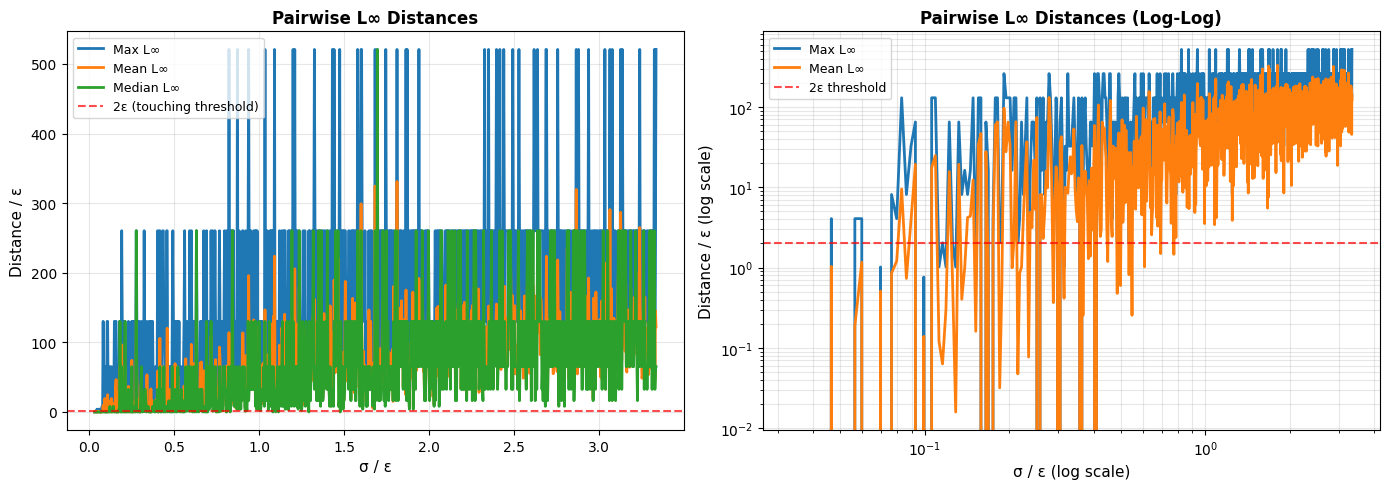

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Left: Distances in units of ε
ax = axes[0]
ax.plot(sigma_array / EPSILON, max_l_inf / EPSILON, label='Max L∞', linewidth=2)
ax.plot(sigma_array / EPSILON, mean_l_inf / EPSILON, label='Mean L∞', linewidth=2)
ax.plot(sigma_array / EPSILON, median_l_inf / EPSILON, label='Median L∞', linewidth=2)
ax.axhline(2, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='2ε (touching threshold)')
ax.set_xlabel("σ / ε", fontsize=11)
ax.set_ylabel("Distance / ε", fontsize=11)
ax.set_title("Pairwise L∞ Distances", fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

# Right: Log-log scale
ax = axes[1]
ax.loglog(sigma_array / EPSILON, max_l_inf / EPSILON, label='Max L∞', linewidth=2)
ax.loglog(sigma_array / EPSILON, mean_l_inf / EPSILON, label='Mean L∞', linewidth=2)
ax.axhline(2, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='2ε threshold')
ax.set_xlabel("σ / ε (log scale)", fontsize=11)
ax.set_ylabel("Distance / ε (log scale)", fontsize=11)
ax.set_title("Pairwise L∞ Distances (Log-Log)", fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Find Optimal σ Ranges

In [8]:
print(f"\n{'='*80}")
print(f"OPTIMAL SIGMA ANALYSIS")
print(f"{'='*80}\n")

# Criterion 1: Max L∞ within 2ε (tight snowball)
tight_snowball_mask = max_l_inf <= 2 * EPSILON
if tight_snowball_mask.any():
    tight_sigmas = sigma_array[tight_snowball_mask]
    print(f"Tight snowball (max L∞ ≤ 2ε):")
    print(f"  σ range: [{tight_sigmas.min():.2e}, {tight_sigmas.max():.2e}]")
    print(f"  σ/ε range: [{tight_sigmas.min()/EPSILON:.2f}, {tight_sigmas.max()/EPSILON:.2f}]")
    
    # Check black hole structure in this range
    idx_mid = np.where(tight_snowball_mask)[0][len(tight_sigmas)//2]
    print(f"\n  Example (σ = {sigma_array[idx_mid]:.2e}, {sigma_array[idx_mid]/EPSILON:.2f}× ε):")
    print(f"    Unique vectors: {unique_vectors[idx_mid]}")
    print(f"    Black holes: {n_black_holes[idx_mid]}")
    print(f"    Black hole pop: {black_hole_population[idx_mid]}")
    print(f"    Largest BH: {largest_bh[idx_mid]} tokens")
else:
    print(f"No σ values produce max L∞ ≤ 2ε")
    # Find closest
    closest_idx = np.argmin(np.abs(max_l_inf - 2*EPSILON))
    print(f"\nClosest σ = {sigma_array[closest_idx]:.2e} ({sigma_array[closest_idx]/EPSILON:.2f}× ε)")
    print(f"  Max L∞ = {max_l_inf[closest_idx]:.2e} ({max_l_inf[closest_idx]/EPSILON:.2f}× ε)")

# Criterion 2: Multiple black holes + some singletons (Qwen-like)
qwen_like_mask = (n_black_holes >= 10) & (n_black_holes <= 100) & (n_singletons > 0)
if qwen_like_mask.any():
    qwen_sigmas = sigma_array[qwen_like_mask]
    print(f"\nQwen-like structure (10-100 black holes, with singletons):")
    print(f"  σ range: [{qwen_sigmas.min():.2e}, {qwen_sigmas.max():.2e}]")
    print(f"  σ/ε range: [{qwen_sigmas.min()/EPSILON:.2f}, {qwen_sigmas.max()/EPSILON:.2f}]")
    
    # Best example
    qwen_indices = np.where(qwen_like_mask)[0]
    # Prefer max L∞ closest to 2ε
    best_idx = qwen_indices[np.argmin(np.abs(max_l_inf[qwen_indices] - 2*EPSILON))]
    print(f"\n  Best match (σ = {sigma_array[best_idx]:.2e}, {sigma_array[best_idx]/EPSILON:.2f}× ε):")
    print(f"    Unique vectors: {unique_vectors[best_idx]}")
    print(f"    Black holes: {n_black_holes[best_idx]}")
    print(f"    Singletons: {n_singletons[best_idx]}")
    print(f"    Black hole pop: {black_hole_population[best_idx]}")
    print(f"    Max L∞: {max_l_inf[best_idx]:.2e} ({max_l_inf[best_idx]/EPSILON:.2f}× ε)")
    print(f"    % touching: {pct_touching[best_idx]:.1f}%")
else:
    print(f"\nNo σ values produce Qwen-like structure")

# Criterion 3: High deduplication (50%+ tokens in black holes)
high_dedup_mask = black_hole_population >= 0.5 * VOCAB_SIZE
if high_dedup_mask.any():
    dedup_sigmas = sigma_array[high_dedup_mask]
    print(f"\nHigh deduplication (≥50% tokens in black holes):")
    print(f"  σ range: [{dedup_sigmas.min():.2e}, {dedup_sigmas.max():.2e}]")
    print(f"  σ/ε range: [{dedup_sigmas.min()/EPSILON:.2f}, {dedup_sigmas.max()/EPSILON:.2f}]")

print(f"\n{'='*80}")


OPTIMAL SIGMA ANALYSIS

Tight snowball (max L∞ ≤ 2ε):
  σ range: [1.00e-06, 1.22e-05]
  σ/ε range: [0.03, 0.41]

  Example (σ = 3.38e-06, 0.11× ε):
    Unique vectors: 2
    Black holes: 2
    Black hole pop: 128
    Largest BH: 120 tokens

Qwen-like structure (10-100 black holes, with singletons):
  σ range: [4.37e-06, 1.00e-04]
  σ/ε range: [0.15, 3.33]

  Best match (σ = 8.63e-06, 0.29× ε):
    Unique vectors: 24
    Black holes: 19
    Singletons: 5
    Black hole pop: 123
    Max L∞: 4.39e-05 (1.46× ε)
    % touching: 100.0%

High deduplication (≥50% tokens in black holes):
  σ range: [1.00e-06, 9.94e-05]
  σ/ε range: [0.03, 3.31]



## Summary Statistics

In [9]:
print(f"\n{'='*80}")
print(f"SUMMARY STATISTICS")
print(f"{'='*80}")
print(f"Sweep range: σ ∈ [{SIGMA_MIN:.2e}, {SIGMA_MAX:.2e}]")
print(f"  In units of ε: [{SIGMA_MIN/EPSILON:.2f}, {SIGMA_MAX/EPSILON:.2f}]× ε")
print(f"Samples: {N_SAMPLES:,}")
print(f"\nVocabulary: {VOCAB_SIZE} tokens")
print(f"Embedding dimension: {HIDDEN_DIM}D")
print(f"Reference scale: ε = {EPSILON:.2e}")
print(f"\nKey transitions:")

# Find transition points
# 1. Where do we go from 1 black hole to multiple?
multi_bh_idx = np.where(n_black_holes > 1)[0]
if len(multi_bh_idx) > 0:
    transition_sigma = sigma_array[multi_bh_idx[0]]
    print(f"  Multiple black holes start at: σ ≈ {transition_sigma:.2e} ({transition_sigma/EPSILON:.2f}× ε)")

# 2. Where do singletons appear?
singleton_idx = np.where(n_singletons > 0)[0]
if len(singleton_idx) > 0:
    singleton_sigma = sigma_array[singleton_idx[0]]
    print(f"  Singletons appear at: σ ≈ {singleton_sigma:.2e} ({singleton_sigma/EPSILON:.2f}× ε)")

# 3. Where does max L∞ exceed 2ε?
exceed_idx = np.where(max_l_inf > 2*EPSILON)[0]
if len(exceed_idx) > 0:
    exceed_sigma = sigma_array[exceed_idx[0]]
    print(f"  Max L∞ exceeds 2ε at: σ ≈ {exceed_sigma:.2e} ({exceed_sigma/EPSILON:.2f}× ε)")

print(f"\n{'='*80}")


SUMMARY STATISTICS
Sweep range: σ ∈ [1.00e-06, 1.00e-04]
  In units of ε: [0.03, 3.33]× ε
Samples: 1,000

Vocabulary: 128 tokens
Embedding dimension: 64D
Reference scale: ε = 3.00e-05

Key transitions:
  Multiple black holes start at: σ ≈ 1.40e-06 (0.05× ε)
  Singletons appear at: σ ≈ 1.40e-06 (0.05× ε)
  Max L∞ exceeds 2ε at: σ ≈ 1.40e-06 (0.05× ε)



## Export Data

In [10]:
import pandas as pd
from pathlib import Path

# Create DataFrame
df = pd.DataFrame(results)

# Save to CSV
output_dir = Path("../data/analysis")
output_dir.mkdir(parents=True, exist_ok=True)
output_file = output_dir / "initialization_sigma_sweep.csv"

df.to_csv(output_file, index=False)

print(f"\n✓ Data exported to {output_file}")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {list(df.columns)}")


✓ Data exported to ../data/analysis/initialization_sigma_sweep.csv
  Rows: 1,000
  Columns: ['sigma', 'unique_vectors', 'n_black_holes', 'black_hole_population', 'n_singletons', 'largest_bh', 'max_l_inf', 'mean_l_inf', 'median_l_inf', 'pct_touching']
